In [1]:
import jax
# NUTS sampling was faster with cpu in this case
jax.config.update('jax_platform_name', 'cpu')

import jax.numpy as jnp
import jax.random as jr

import arviz as az
import arviz.labels as azl

import einops
import os

key = jr.PRNGKey(0)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import tensorflow_probability.substrates.jax as tfp

2024-01-08 14:24:21.084923: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-08 14:24:21.456409: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-08 14:24:21.456468: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-01-08 14:24:21.456473: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [2]:
from preprocessing import load_data,generate_indices,generate_XY,generate_indices_cumulative
from models import gen_model,sigmoid,run_nuts,mean_predictions,gen_predictive,diagnostics,increase_in_heterogeneity
from plots import prior_predictive,plot_posterior,posterior_comparisons,\
    plot_mean,plot_heterogeneity,compare_heterogeneity,compare_micromacro

Normalize data and generate necessary indices for different effects

In [3]:
data,macro = load_data('data')
macro_type_indices,radius_indices,\
radius_orig,type_indices,type_orig,\
coating_indices,coating_orig,\
temp_indices,temp_orig,concentration_indices,\
concentration_orig,cross_indices= generate_indices(data,macro)

crosslinker,crosslinker_raw,c_mean,c_std,crosslinker_macro,crosslinker_macro_raw,\
            G,G_macro = generate_XY(data,macro,'G')

_,_,_,_,_,_,phi,phi_macro = generate_XY(data,macro,'phi')

cross_unique,cross_unique_alg,cross_unique_ipn,indices,cross_unique_macro,\
cross_unique_macro_alg,cross_unique_macro_ipn,indices_macro,micro_coords,\
macro_coords,indices_typed,indices_typed_macro,micro_alg_indices,micro_ipn_indices,\
micro_mu_indices,macro_alg_indices,macro_ipn_indices,macro_mu_indices,N_alg,N_ipn,\
N_macro,N_macro_alg,N_macro_ipn,N,N_radius,N_coating,N_micro,N_macro,sample_indices,\
holder_indices,N_dat_samples,\
N_holders,cross_all,concentration,temperature,types,G_names,G_macro_names = generate_indices_cumulative(data,crosslinker,type_indices,
                                                                                crosslinker_macro,macro_type_indices,
                                                                                radius_indices,coating_indices)

Fit switchpoint model for |G*|

In [4]:
model_type = 'switchpoint'
mec_type = 'G'
naming = '|G^*|'
units = 'Pa'

xlabel = 'Crosslinker concentration [mM]'

In [5]:
model = gen_model(crosslinker,concentration,temperature,cross_all,c_mean,c_std,N,N_coating,N_holders,N_dat_samples,N_radius,\
              coating_indices,holder_indices,sample_indices,radius_indices,cross_unique_alg,cross_unique_ipn,\
              cross_unique_macro_alg,cross_unique_macro_ipn,micro_coords,indices_typed,micro_mu_indices,types,\
              macro_coords,indices_typed_macro,macro_mu_indices,model_type)

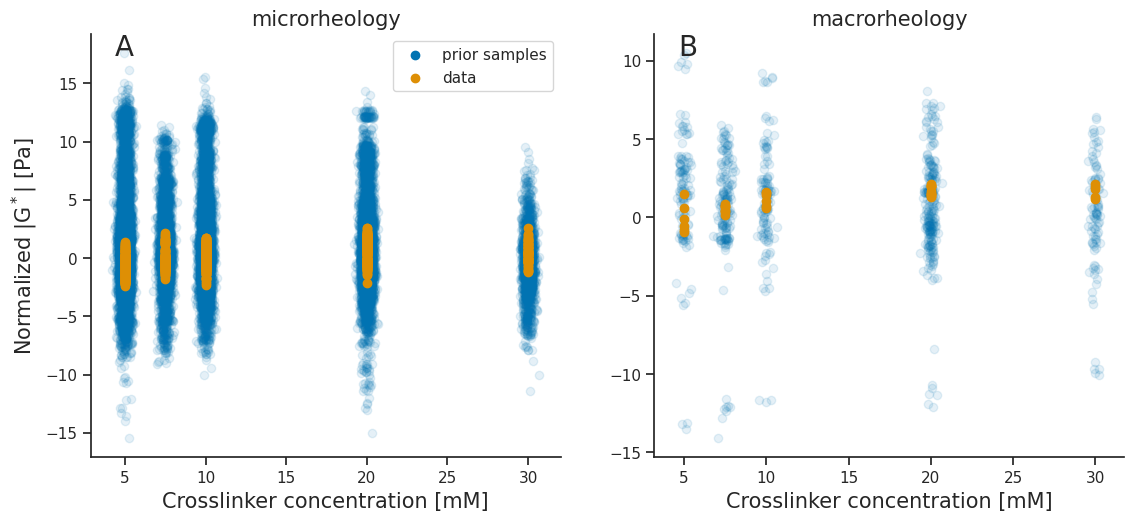

In [6]:
target = model.experimental_pin(likelihood=G,likelihood_macro=G_macro)
bijector = target.experimental_default_event_space_bijector()
n_prior = 20
init_samples = model.sample(n_prior,seed=key)
prior_predictive(model,n_prior,crosslinker_raw,crosslinker,crosslinker_macro_raw,
                     crosslinker_macro,G,G_macro,units,naming,xlabel,mec_type,key)
states,log_probs = run_nuts(model.sample(seed=key),target,bijector,model,key)

/home/lab/miniconda3/envs/tfp/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


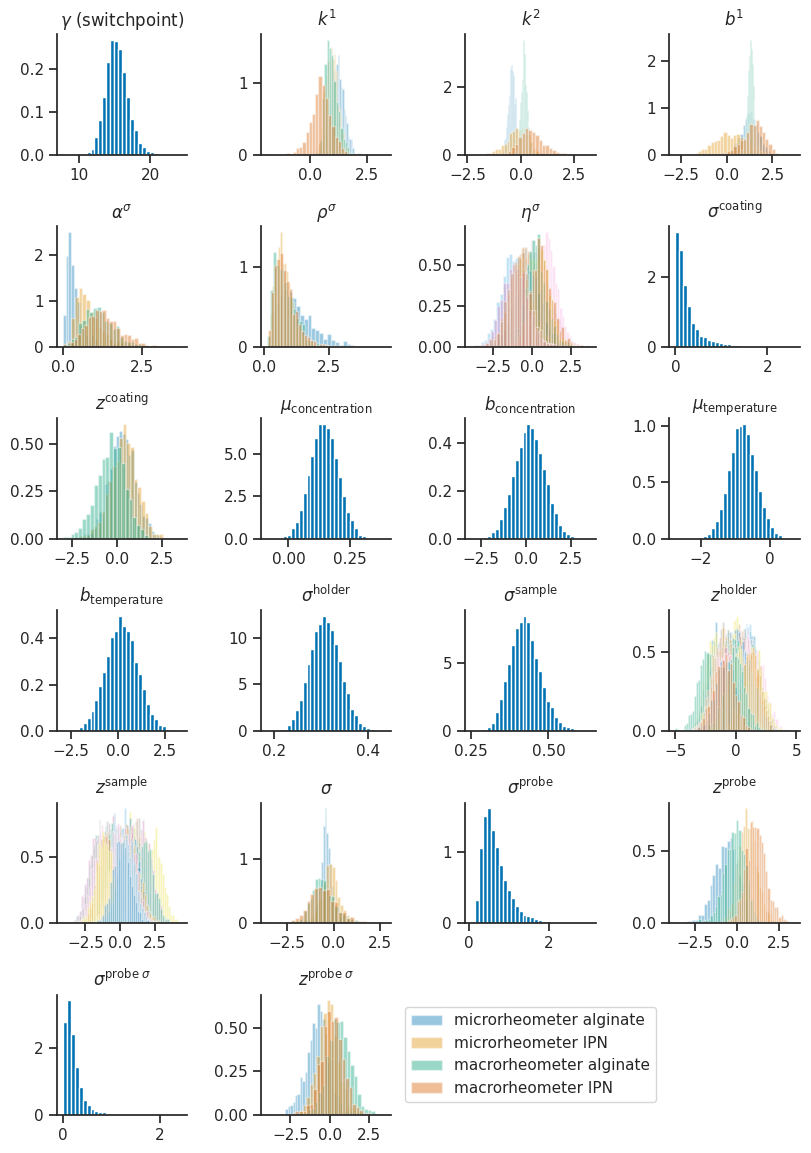

In [7]:
plot_posterior(jax.tree_util.tree_map(lambda x: jnp.squeeze(x),states),c_std,c_mean,'switchpoint',mec_type)

Diagnostics

In [8]:
# rhat
jax.tree_map(lambda x: (x>1.1).sum().tolist(),tfp.mcmc.potential_scale_reduction(states))

StructTuple(
  switchpoint=0,
  slope1=0,
  slope2=0,
  intercept=0,
  sigma_alpha=0,
  sigma_rho=0,
  sigma_eta=0,
  coating_std=0,
  coating_z=0,
  concentration_mu=0,
  concentration_intercept=0,
  temperature_mu=0,
  temperature_intercept=0,
  holder_std=0,
  sample_std=0,
  holder_z=0,
  sample_z=0,
  sigma_mu=0,
  radius_std=0,
  radius_z=0,
  radius_sigma_std=0,
  radius_sigma_z=0
)

/home/lab/miniconda3/envs/tfp/lib/python3.10/site-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (27), generating only 20 plots
  warnings.warn(


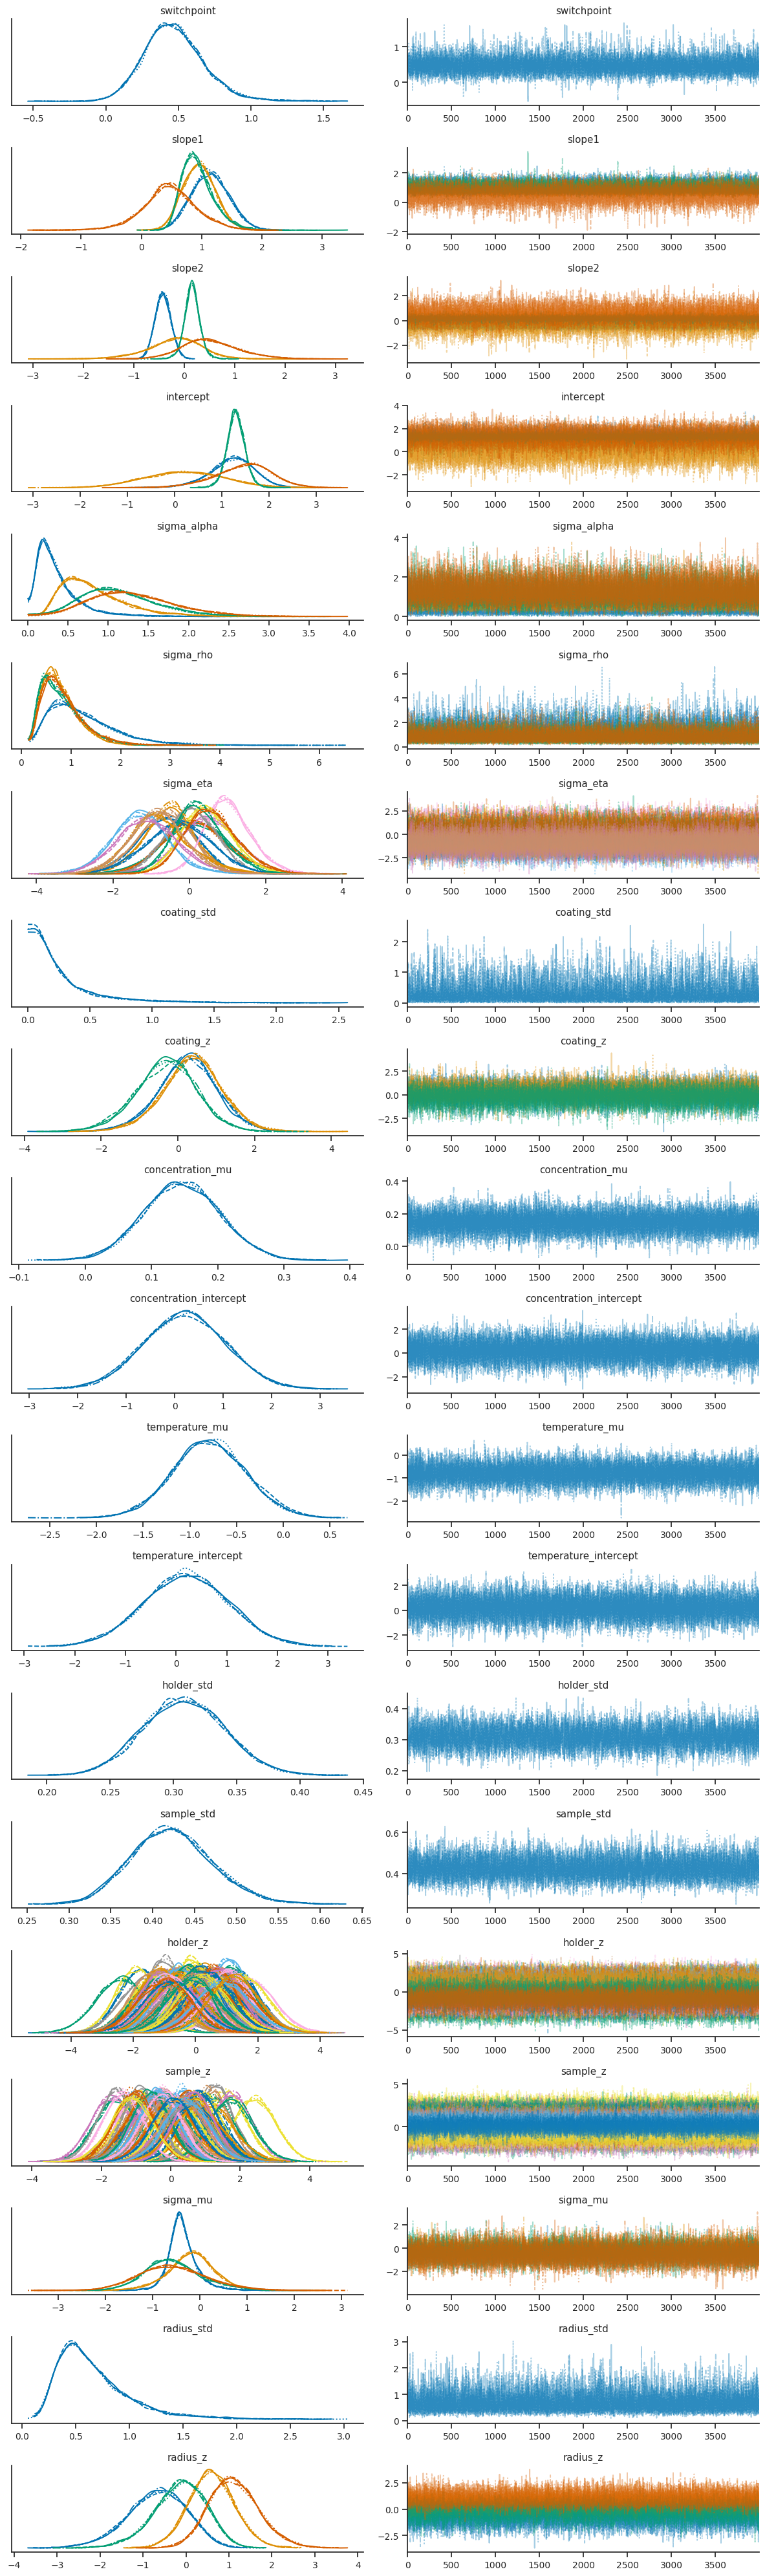

In [9]:
samps = gen_predictive(model,jax.tree_map(lambda x: jnp.squeeze(x),states))
trace = diagnostics(jax.tree_map(lambda x: jnp.squeeze(x),states),log_probs,samps,radius_orig,coating_orig,G_names,G_macro_names,G,G_macro,model_type)
ax = az.plot_trace(trace)
ax[0,0].figure.tight_layout()

In [10]:
summary = az.summary(trace,filter_vars='regex',var_names=['~eta']).filter(items=["mean", "hdi_3%", "hdi_97%", "ess_bulk", "r_hat"])

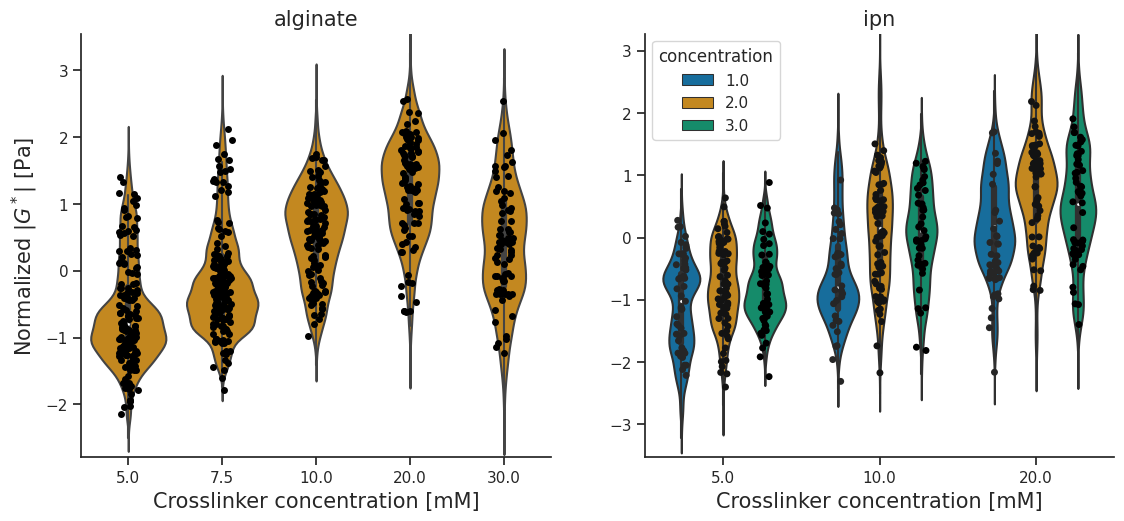

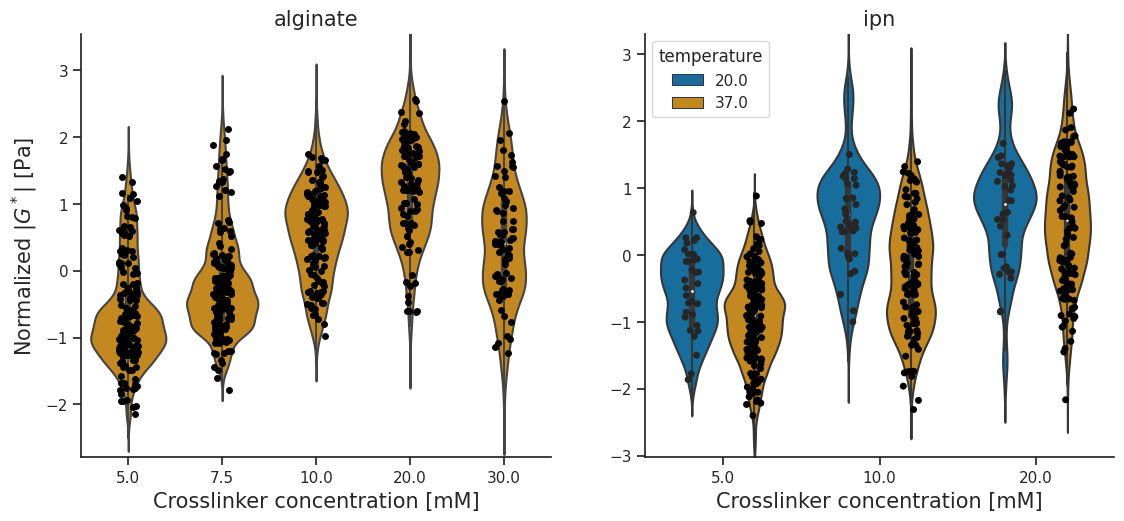

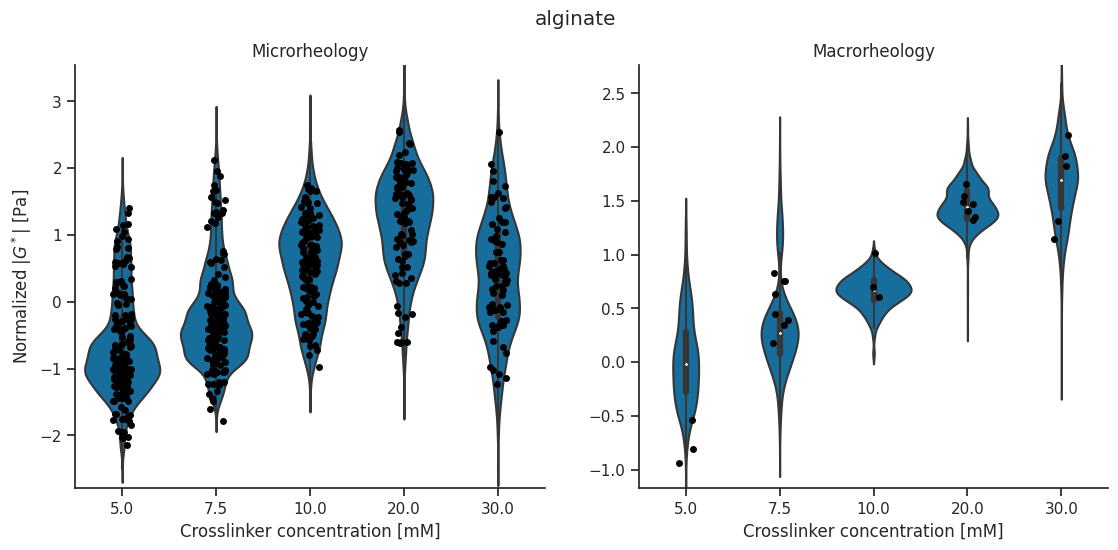

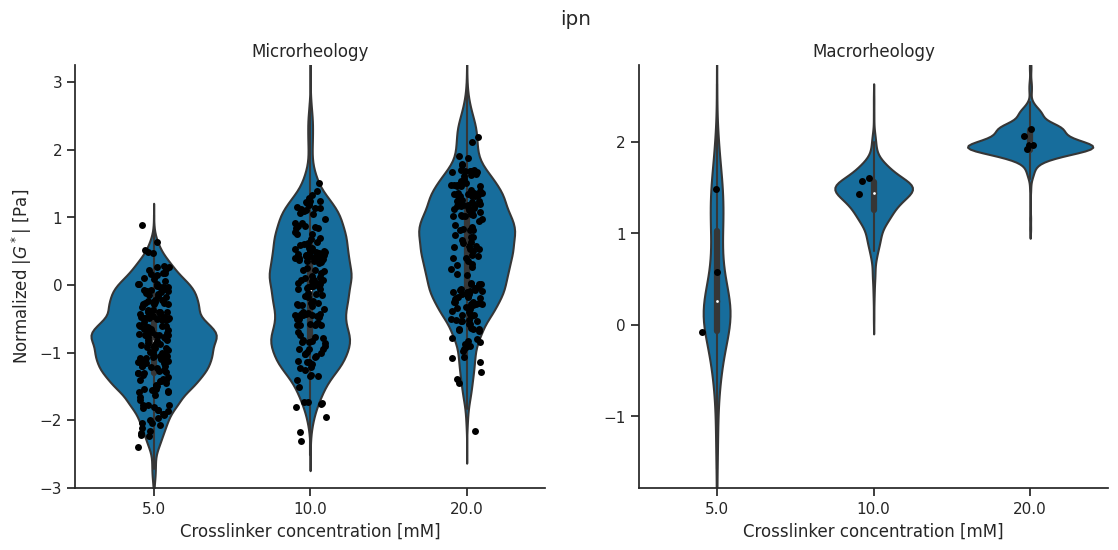

In [11]:
posterior_comparisons(data,macro,samps,states,crosslinker_macro_raw,crosslinker_raw,G,G_macro,xlabel,naming,units,mec_type)

Generate posterior predictive and draw results

In [12]:
N_pred = 100
c_pred = jnp.linspace(crosslinker.min(),crosslinker.max(),N_pred)

m1 = jnp.concatenate([np.zeros(N_alg),np.ones(N_ipn)]).astype(int)
m2 = jnp.concatenate([np.zeros(N_macro_alg),np.ones(N_macro_ipn)]).astype(int)+2

m1_ = jnp.concatenate([np.zeros(N_alg),np.zeros(N_pred),np.ones(N_ipn),np.ones(N_pred)]).astype(int)

m2_ = jnp.concatenate([np.zeros(N_alg),np.zeros(N_pred),
                       np.ones(N_ipn),np.ones(N_pred),
                       np.zeros(N_macro_alg),np.zeros(N_pred),
                       np.ones(N_macro_ipn),np.ones(N_pred)]).astype(int)

Compare macro to micro

In [13]:
curve,curve_datapoints,sigma,N_split = mean_predictions(jax.tree_map(lambda x: jnp.squeeze(x),states),cross_unique_alg,cross_unique_ipn,cross_unique_macro_alg,
                            cross_unique_macro_ipn,cross_unique,
                            N_pred,N_alg,N_ipn,N_micro,N_macro_alg,N_macro_ipn,c_pred,m2_,key,model_type)


Is macro larger than micro?

In [14]:
print(((curve_datapoints[:,2]-curve_datapoints[:,0])>0.1).sum()/np.prod(curve_datapoints[:,2].shape)*100)
print(((curve_datapoints[:,3]-curve_datapoints[:,1])>0.1).sum()/np.prod(curve_datapoints[:,2].shape)*100)

92.09895
98.17466


Is macro larger than micro (at different crosslinker values)

In [15]:
def micromacro_diff(x,i,j,label):
    x1 = x[:,i]
    x2 = x[:,j]
    diff = x2-x1

    print(label,(diff>0.1).sum(axis=0)/diff.shape[0]*100)
micromacro_diff(curve_datapoints,0,2,'alginate')
micromacro_diff(curve_datapoints,1,3,'ipn')

alginate [90.06747 89.37407 87.01274 94.17167 99.86881]
ipn [98.875565 98.575714 98.25712  98.27586  96.88905 ]


Blue is alginate, orange is IPN. Upper image is microrheometer, bottom is macrorheometer

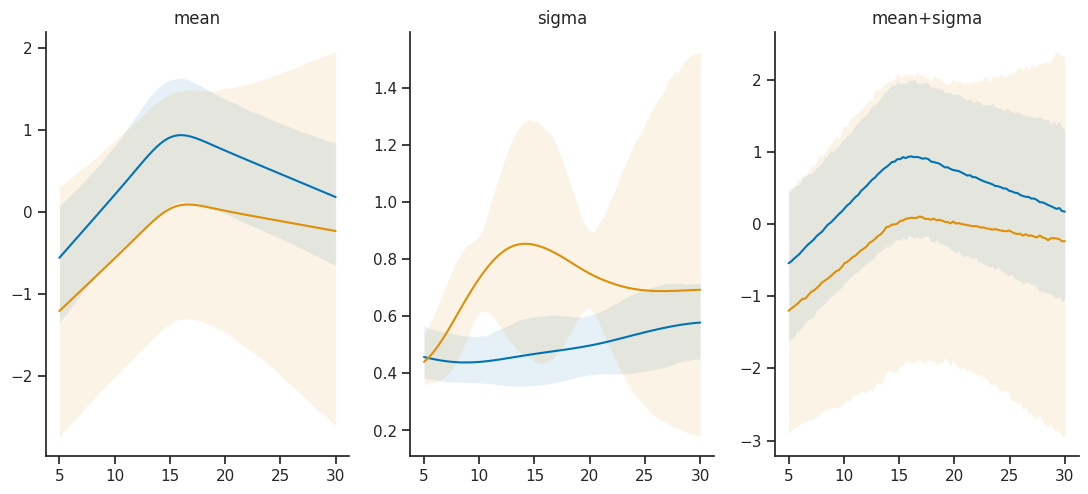

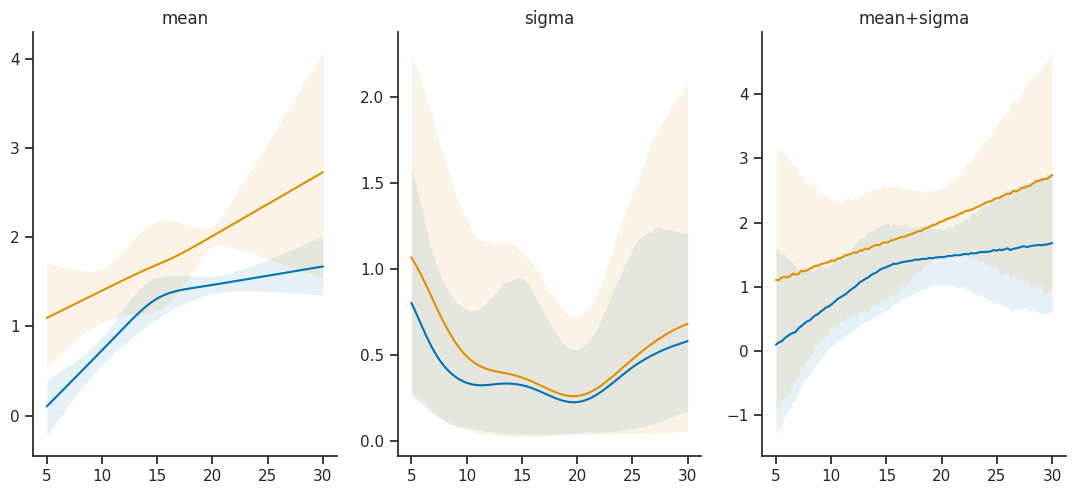

In [16]:
plot_mean(c_pred,c_std,c_mean,curve,sigma,N_alg,N_pred,N_ipn,N_split,N_macro_alg,
              N_macro_ipn)

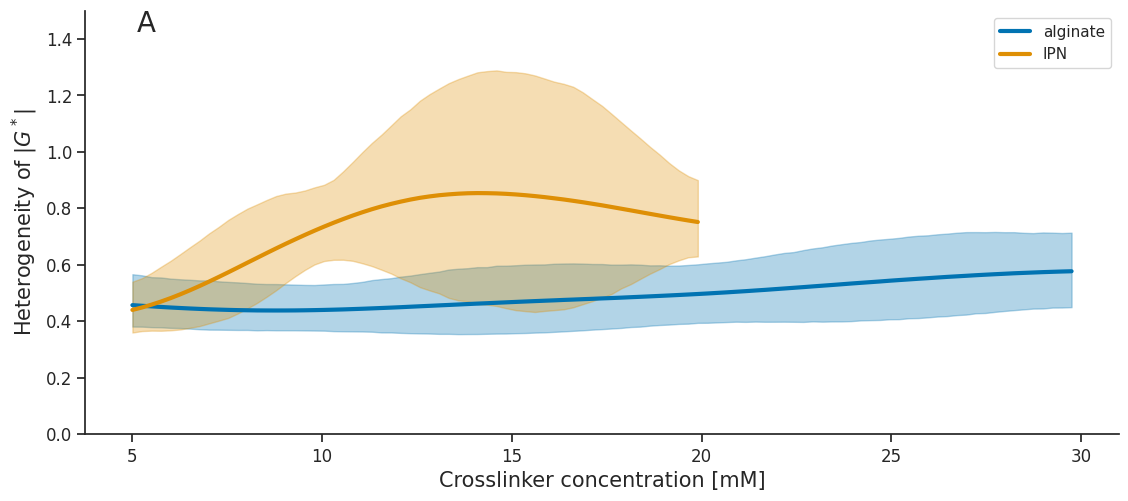

In [17]:
plot_heterogeneity(N_alg,N_ipn,N_pred,c_pred,crosslinker,type_indices,sigma,c_std,c_mean,naming,units,xlabel,mec_type)

Slope being positive

In [18]:
names = ['micro alginate','micro ipn','macro alginate','macro ipn']
for k in [jnp.squeeze(states.slope1),jnp.squeeze(states.slope2)]:
    ee = einops.rearrange(k, 'i j l -> (i j) l')
    for i,j in zip(range(ee.shape[-1]),names):
        print(np.sum(ee[:,i]>0.1)/ee[:,i].shape[0]*100)
    print('---')

99.993744
99.94375
99.993744
81.45
---
0.0375
29.88125
65.631256
77.6625
---


Incrase in heterogeneity

In [19]:
increase_in_heterogeneity(states,cross_unique_alg,cross_unique_ipn,N_micro,c_std,
                              c_mean,N_alg,N_ipn,cross_unique_macro_alg,cross_unique_macro_ipn,
                              N_macro,N_macro_alg,N_macro_ipn,m1,m2)

alginate 10.0 20.0 17.81  
alginate 10.0 30.0 70.11  
alginate 20.0 30.0 36.24  
alginate 5.0 10.0 0.12  
alginate 5.0 20.0 16.64  
alginate 5.0 30.0 59.49  
alginate 5.0 7.5 0.0  
alginate 7.5 10.0 0.34  
alginate 7.5 20.0 21.21  
alginate 7.5 30.0 68.9  
ipn 10.0 20.0 9.69  
ipn 5.0 10.0 99.99 **** 
ipn 5.0 20.0 99.99 **** 


### Some interesting parameters

15.373813


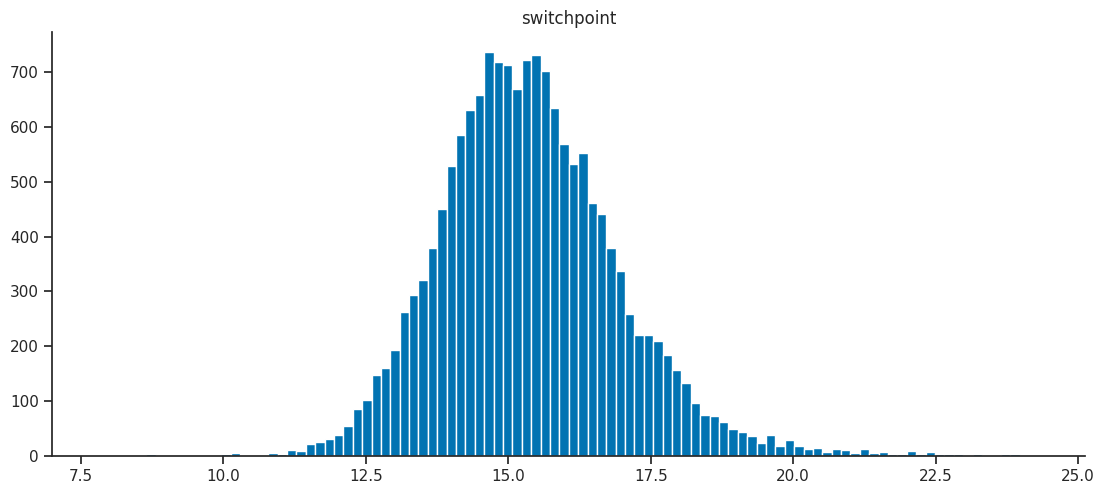

In [20]:
switchpoint = np.array(states.switchpoint.ravel())*c_std+c_mean
_ = plt.hist(switchpoint,bins=100)
plt.title('switchpoint')
print(np.mean(switchpoint))

0.787375


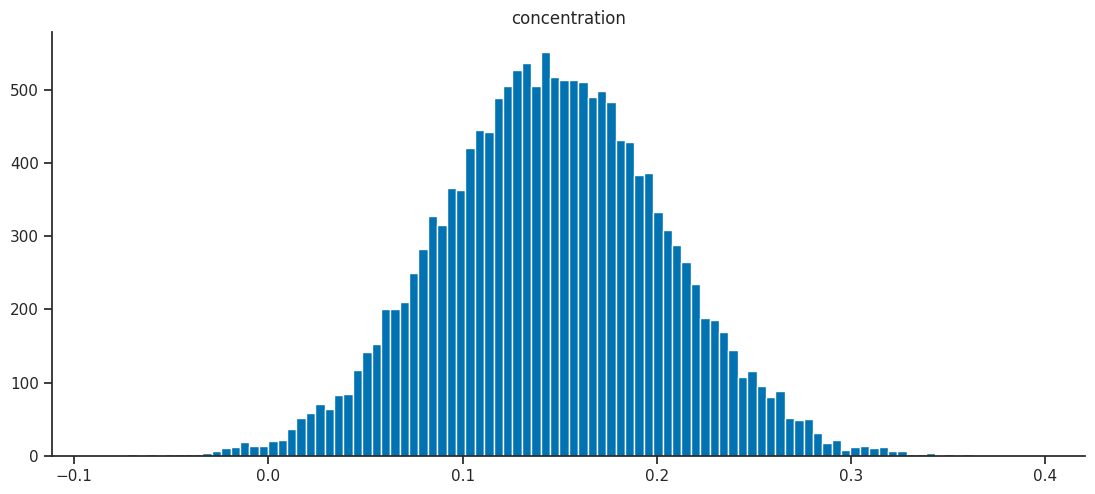

In [21]:
con = np.array(states.concentration_mu.ravel())
_ = plt.hist(con,bins=100)
plt.title('concentration')
print((con>0.1).sum()/con.shape[0])

0.9590625


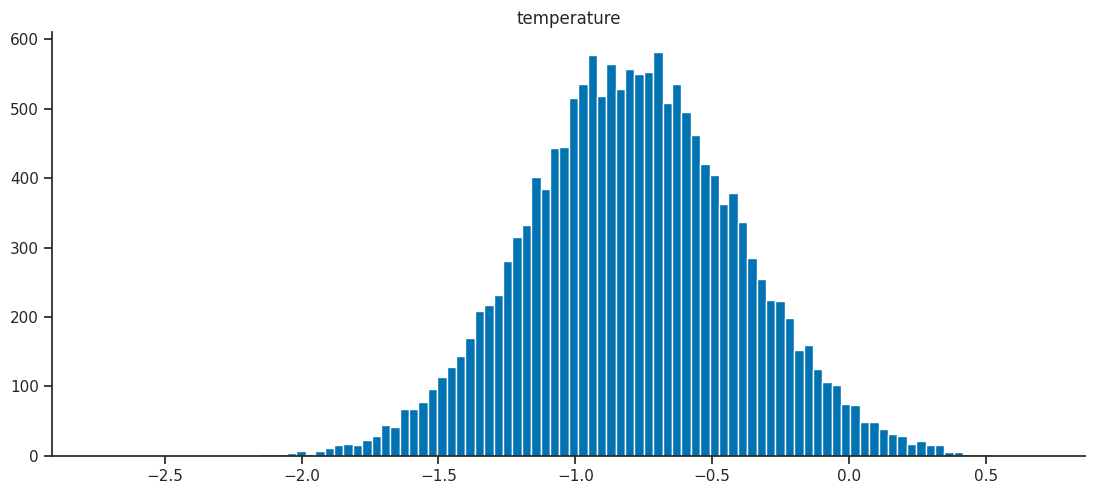

In [22]:
tm = np.array(states.temperature_mu.ravel())
_ = plt.hist(tm,bins=100)
plt.title('temperature')
print((tm<-0.1).sum()/tm.shape[0])

# $\Phi$

In [23]:
model_type = 'linear'
mec_type = 'phi'
naming = '\Phi'
units = 'rad'

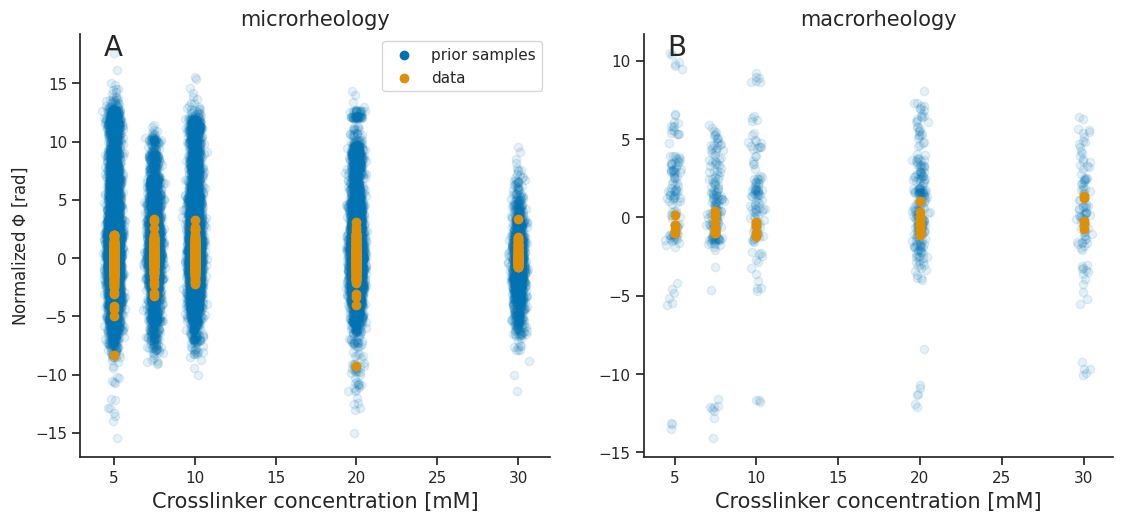

In [24]:
model_phi = gen_model(crosslinker,concentration,temperature,cross_all,c_mean,c_std,N,N_coating,N_holders,N_dat_samples,N_radius,\
              coating_indices,holder_indices,sample_indices,radius_indices,cross_unique_alg,cross_unique_ipn,\
              cross_unique_macro_alg,cross_unique_macro_ipn,micro_coords,indices_typed,micro_mu_indices,types,\
              macro_coords,indices_typed_macro,macro_mu_indices,model_type)

target = model_phi.experimental_pin(likelihood=phi,likelihood_macro=phi_macro)
bijector = target.experimental_default_event_space_bijector()
n_prior = 20
init_samples = model.sample(n_prior,seed=key)
prior_predictive(model,n_prior,crosslinker_raw,crosslinker,crosslinker_macro_raw,
                     crosslinker_macro,phi,phi_macro,units,naming,xlabel,mec_type,key)
states_phi,log_probs_phi = run_nuts(model_phi.sample(seed=key),target,bijector,model_phi,key)

/home/lab/miniconda3/envs/tfp/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


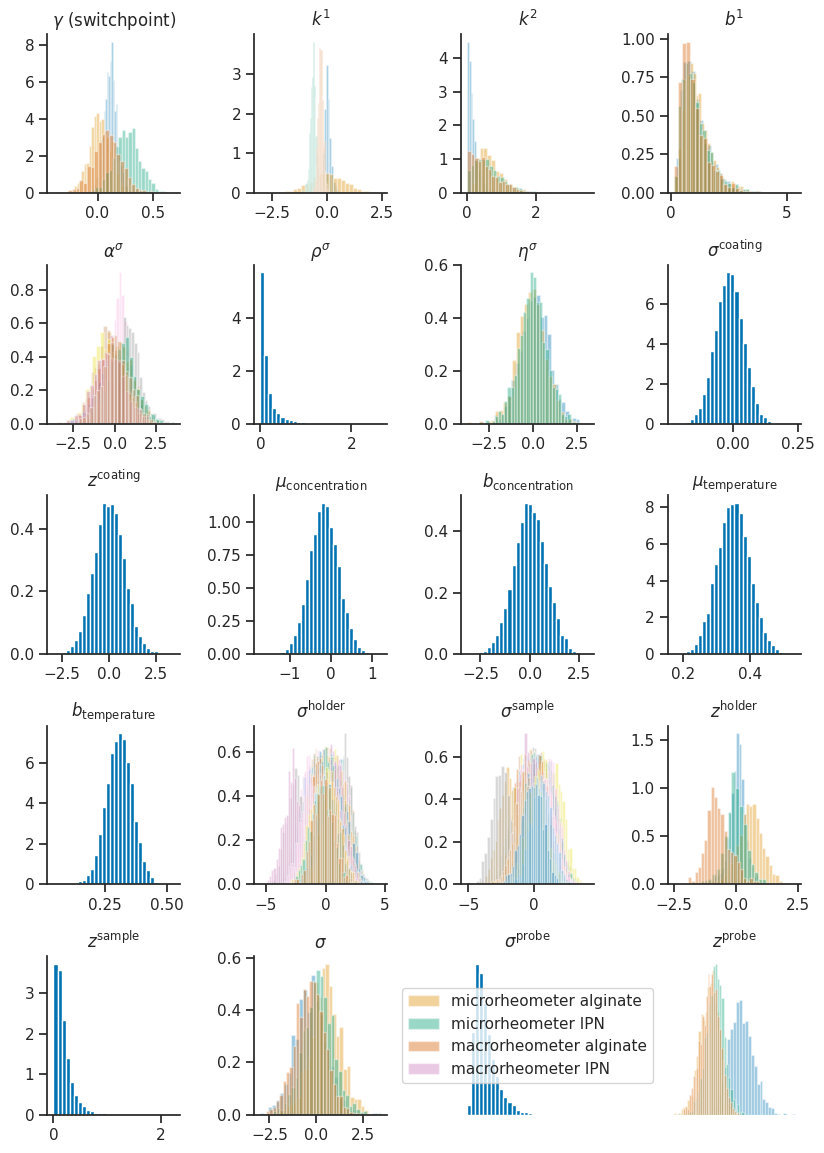

In [25]:
plot_posterior(jax.tree_util.tree_map(lambda x: jnp.squeeze(x),states_phi),c_std,c_mean,'switchpoint',mec_type)

In [26]:
# rhat
jax.tree_map(lambda x: (x>1.1).sum().tolist(),tfp.mcmc.potential_scale_reduction(states_phi))

StructTuple(
  slope1=0,
  intercept=0,
  sigma_alpha=0,
  sigma_rho=0,
  sigma_eta=0,
  coating_std=0,
  coating_z=0,
  concentration_mu=0,
  concentration_intercept=0,
  temperature_mu=0,
  temperature_intercept=0,
  holder_std=0,
  sample_std=0,
  holder_z=0,
  sample_z=0,
  sigma_mu=0,
  radius_std=0,
  radius_z=0,
  radius_sigma_std=0,
  radius_sigma_z=0
)

/home/lab/miniconda3/envs/tfp/lib/python3.10/site-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (25), generating only 20 plots
  warnings.warn(


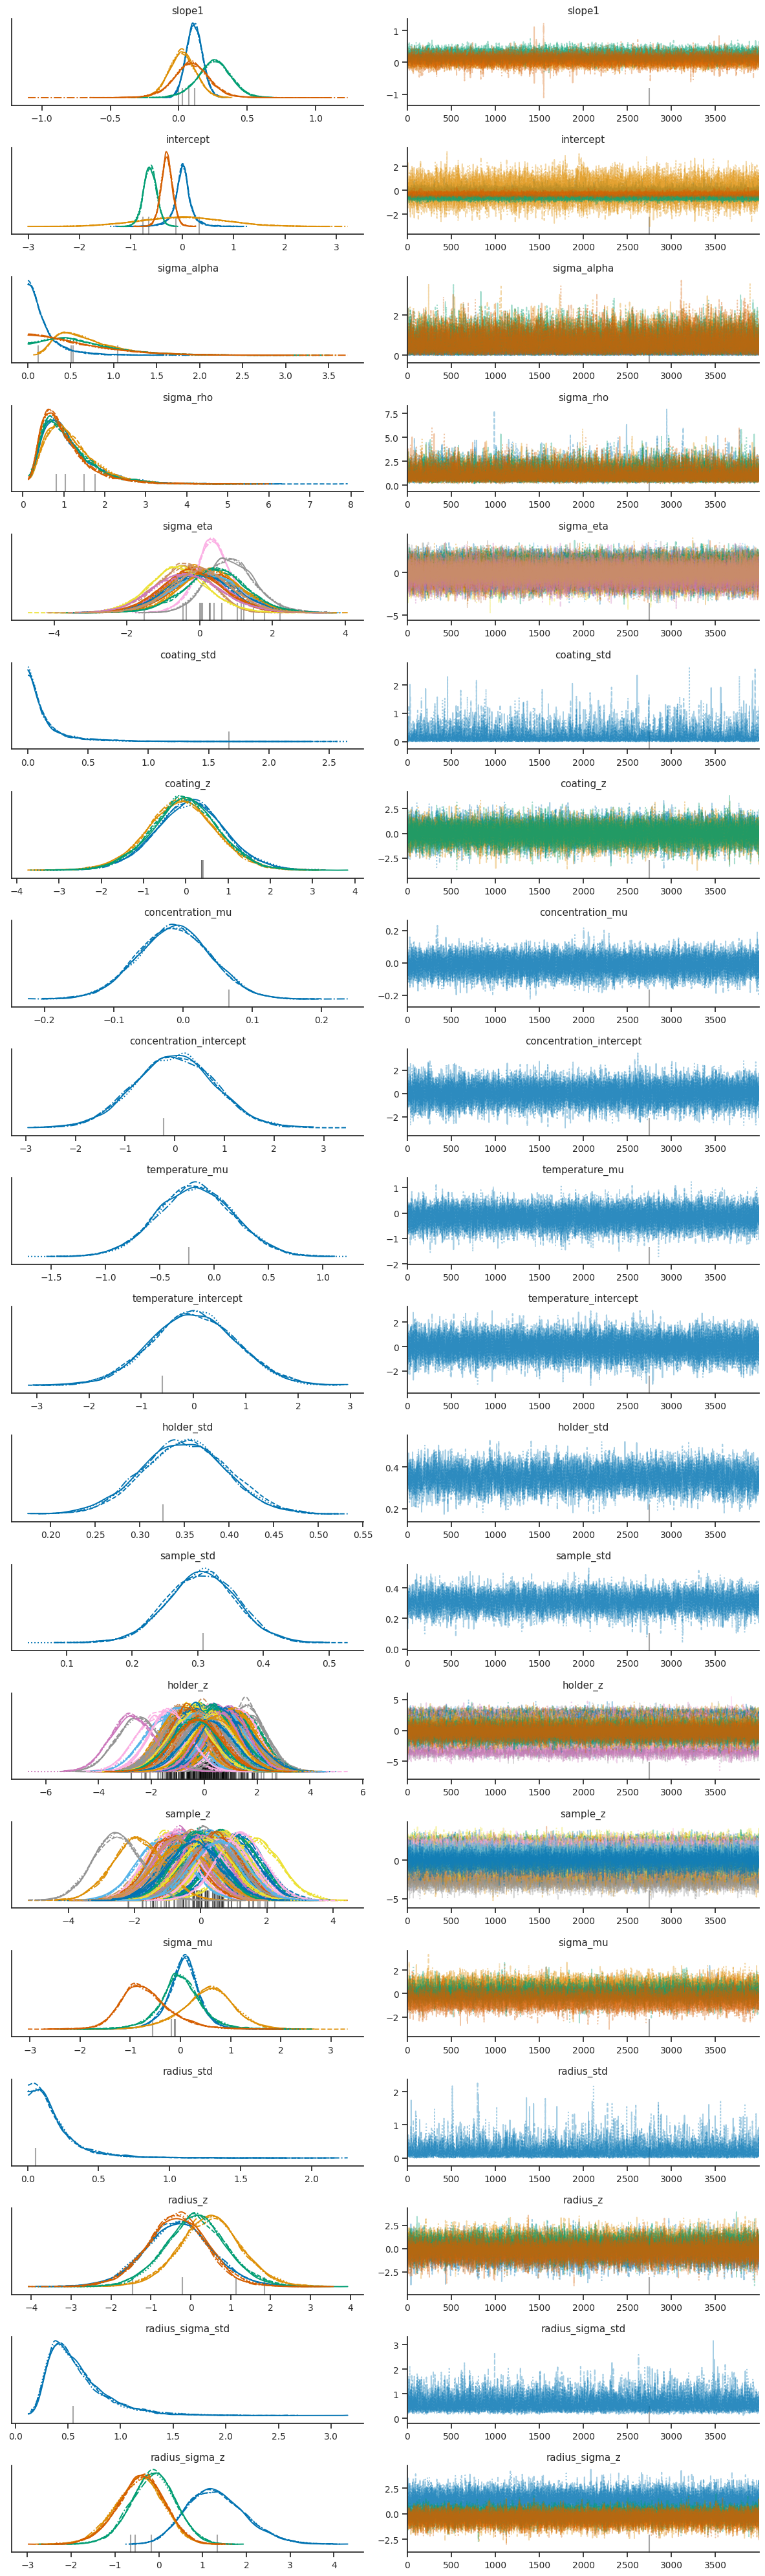

In [27]:
samps_phi = gen_predictive(model_phi,jax.tree_map(lambda x: jnp.squeeze(x),states_phi))
trace_phi = diagnostics(jax.tree_map(lambda x: jnp.squeeze(x),states_phi),log_probs_phi,samps_phi,radius_orig,coating_orig,G_names,G_macro_names,phi,phi_macro,model_type)
ax = az.plot_trace(trace_phi)
ax[0,0].figure.tight_layout()

In [28]:
summary_phi = az.summary(trace_phi,filter_vars='regex',var_names=['~eta']).filter(items=["mean", "hdi_3%", "hdi_97%", "ess_bulk", "r_hat"])

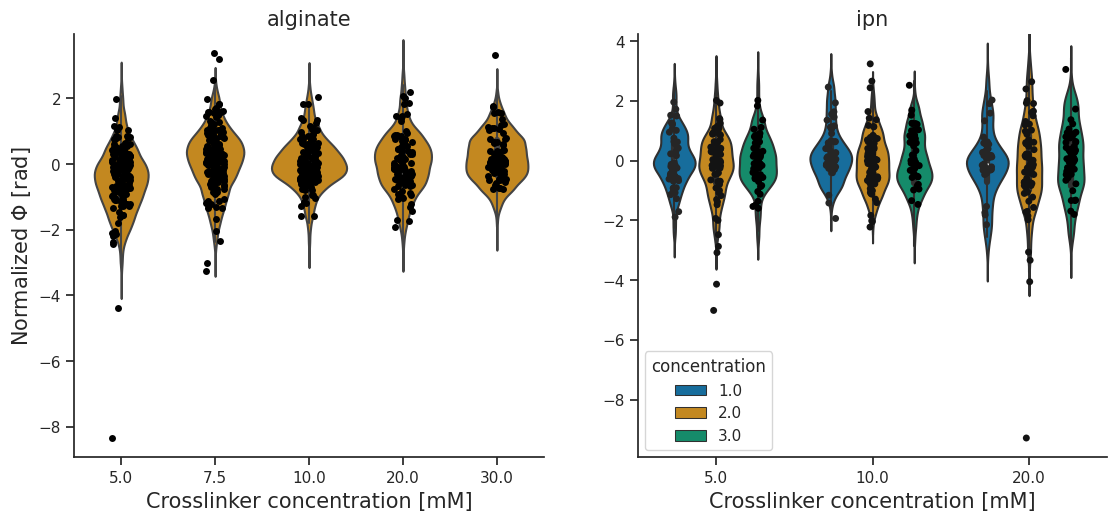

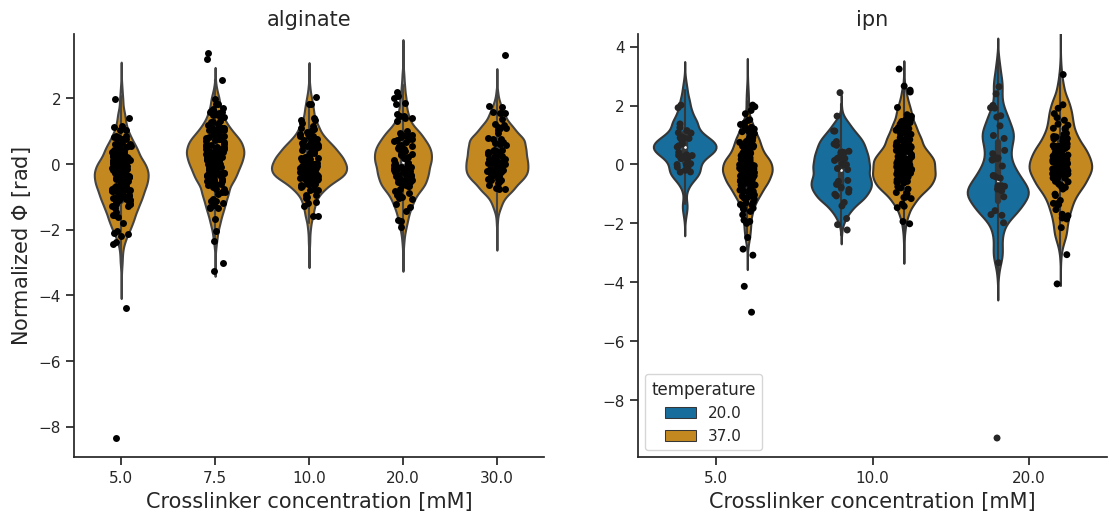

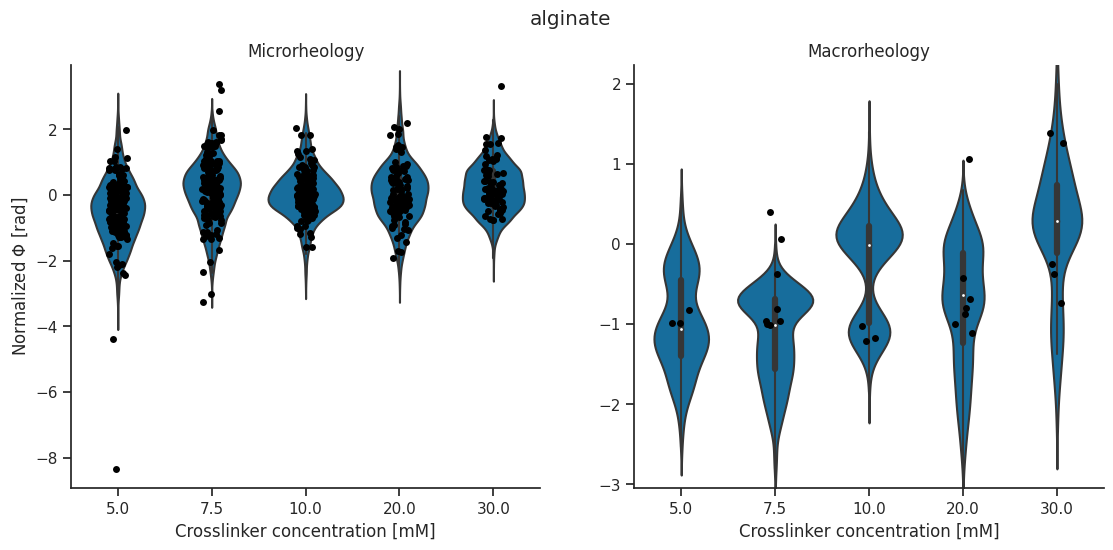

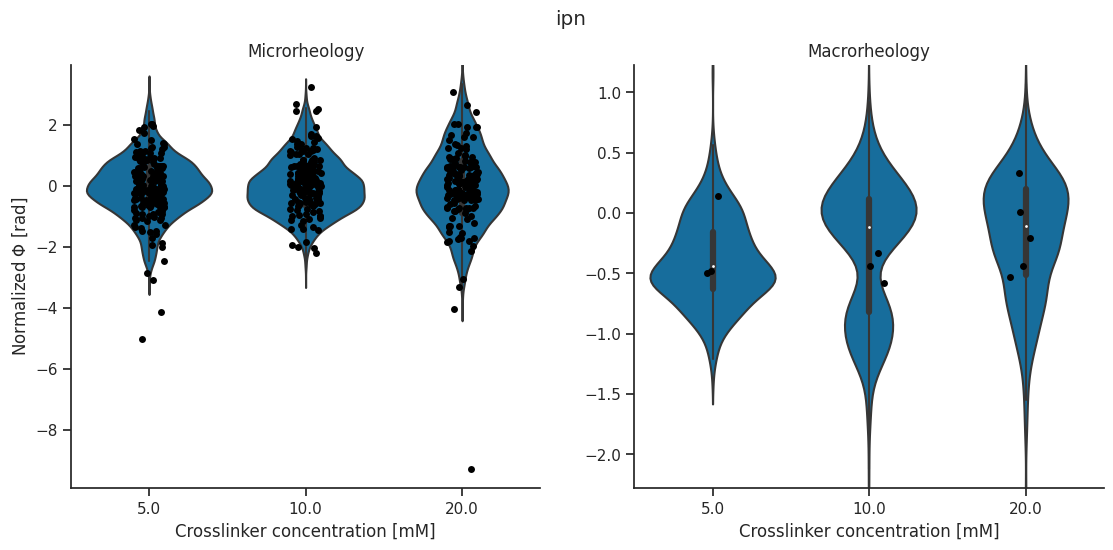

In [29]:
posterior_comparisons(data,macro,samps_phi,states_phi,crosslinker_macro_raw,crosslinker_raw,phi,phi_macro,xlabel,naming,units,mec_type)

In [30]:
from functools import partial
from models import rbf
import jax.nn as jnn
def mean_predictions(states,cross_unique_alg,cross_unique_ipn,cross_unique_macro_alg,cross_unique_macro_ipn,cross_unique,
                     N_pred,N_alg,N_ipn,N_micro,N_macro_alg,N_macro_ipn,c_pred,m2_,key,model_type):

    eta_key,sigma_eta_key = jr.split(key,2)
    #N_samples = states.eta.shape[0]
    num_c = states.sigma_alpha.shape[1]
    sub_sample = 3
    N_samples = states.sigma_rho[::sub_sample].shape[0]

    combined_alg = jnp.concatenate([cross_unique_alg,c_pred])
    combined_ipn = jnp.concatenate([cross_unique_ipn,c_pred])

    combined_macro_alg = jnp.concatenate([cross_unique_macro_alg,c_pred])
    combined_macro_ipn = jnp.concatenate([cross_unique_macro_ipn,c_pred])

    N_combined_alg = combined_alg.shape[0]
    N_combined_ipn = combined_ipn.shape[0]

    N_split = N_combined_alg+N_combined_ipn

    N_combined_macro_alg = combined_macro_alg.shape[0]
    N_combined_macro_ipn = combined_macro_ipn.shape[0]

    N_both = N_combined_alg+N_combined_ipn+N_combined_macro_alg+N_combined_macro_ipn

    if model_type=='switchpoint':
        slope1 = states.slope1[::sub_sample,:][...,None]
        slope2 = states.slope2[::sub_sample,:][...,None]
        #switchpoint = states.switchpoint[::sub_sample,:,:][...,None]
        switchpoint = states.switchpoint[::sub_sample,:][...,None]
        intercept = states.intercept[::sub_sample,:][...,None]
        switch = switchpoint[...,None]
        #switch = switchpoint[:,:,[0,0,1,1]]
        #switch = tfb.Shift((20-c_mean)/c_std).forward(switchpoint)[:,:,[0,0,1,1]]
        i2 = (slope2*switch+intercept)-slope1*switch
        slope = slope2+sigmoid(switch-c_pred[None,None,None,...],10)*(slope1-slope2)
        inter = intercept+sigmoid(switch-c_pred[None,None,None,...],10)*(i2-intercept)
        curve = slope*c_pred[None,None,None,...]+inter

        slope_datapoints = slope2+sigmoid(switch-cross_unique[None,None,None,...],10)*(slope1-slope2)
        inter_datapoints = intercept+sigmoid(switch-cross_unique[None,None,None,...],10)*(i2-intercept)
        curve_datapoints = slope_datapoints*cross_unique[None,None,None,...]+inter_datapoints
    else:
        slope1 = states.slope1[::sub_sample,:][...,None]
        intercept = states.intercept[::sub_sample,:][...,None]
        curve = slope1*c_pred[None,None,None,...]+intercept
        curve_datapoints = slope1*cross_unique[None,None,None,...]+intercept


    eta_pred_sigma = jr.normal(sigma_eta_key,(*states.sigma_eta.shape[:2],N_pred))
    eta_both_sigma = jnp.dstack([states.sigma_eta[...,:N_alg],eta_pred_sigma,
                                states.sigma_eta[...,N_alg:(N_alg+N_ipn)],eta_pred_sigma,
                                states.sigma_eta[...,N_micro:(N_micro+N_macro_alg)],eta_pred_sigma,
                                states.sigma_eta[...,(N_micro+N_macro_alg):((N_micro+N_macro_alg+N_macro_ipn))],eta_pred_sigma])


    N_total_sigma = eta_both_sigma.shape[-1]

    K_sigma = jax.vmap(jax.vmap(jax.scipy.linalg.block_diag))(
                    # micro
                    einops.rearrange(jax.vmap(partial(rbf,combined_alg[...,None]))(
                    einops.rearrange(states.sigma_alpha[::sub_sample,:,0],'n c -> (n c)'),
                    einops.rearrange(states.sigma_rho[::sub_sample,:,0],'n c -> (n c)'))[...,0],
                    '(n c) a b -> n c a b',n=N_samples,c=num_c),

                    einops.rearrange(jax.vmap(partial(rbf,combined_ipn[...,None]))(
                    einops.rearrange(states.sigma_alpha[::sub_sample,:,1],'n c -> (n c)'),
                    einops.rearrange(states.sigma_rho[::sub_sample,:,1],'n c -> (n c)'))[...,0],
                    '(n c) a b -> n c a b',n=N_samples,c=num_c),
                    # macro
                    einops.rearrange(jax.vmap(partial(rbf,combined_macro_alg[...,None]))(
                    einops.rearrange(states.sigma_alpha[::sub_sample,:,2],'n c -> (n c)'),
                    einops.rearrange(states.sigma_rho[::sub_sample,:,2],'n c -> (n c)'))[...,0],
                    '(n c) a b -> n c a b',n=N_samples,c=num_c),
                    
                    einops.rearrange(jax.vmap(partial(rbf,combined_macro_ipn[...,None]))(
                    einops.rearrange(states.sigma_alpha[::sub_sample,:,3],'n c -> (n c)'),
                    einops.rearrange(states.sigma_rho[::sub_sample,:,3],'n c -> (n c)'))[...,0],
                    '(n c) a b -> n c a b',n=N_samples,c=num_c)) + jnp.eye(N_both)[None,None,...]*(1e-4)

    L_K_sigma = jnp.linalg.cholesky(K_sigma)

    sigma = jnn.softplus(jnp.einsum('nmij,nmj->nmi',L_K_sigma,eta_both_sigma[::sub_sample])+states.sigma_mu[::sub_sample,:,m2_])
    curve_datapoints = einops.rearrange(curve_datapoints,'i j k n -> (i j) k n')
    return curve,curve_datapoints,sigma,N_split

is macro smaller than micro?

In [31]:
curve_phi,curve_datapoints_phi,sigma_phi,_ = mean_predictions(jax.tree_map(lambda x: jnp.squeeze(x),states_phi),cross_unique_alg,cross_unique_ipn,cross_unique_macro_alg,
                            cross_unique_macro_ipn,cross_unique,
                            N_pred,N_alg,N_ipn,N_micro,N_macro_alg,N_macro_ipn,c_pred,m2_,key,model_type)

print(((curve_datapoints_phi[:,2]-curve_datapoints_phi[:,0])<-0.1).sum()/np.prod(curve_datapoints_phi[:,2].shape)*100)
print(((curve_datapoints_phi[:,3]-curve_datapoints_phi[:,1])<-0.1).sum()/np.prod(curve_datapoints_phi[:,2].shape)*100)


91.33058
57.85607


In [32]:
def micromacro_diff(x,i,j,label):
    x1 = x[:,i]
    x2 = x[:,j]
    diff = x2-x1

    print(label,(diff<-0.1).sum(axis=0)/diff.shape[0]*100)
micromacro_diff(curve_datapoints_phi,0,2,'alginate')
micromacro_diff(curve_datapoints_phi,1,3,'ipn')

alginate [98.65067  98.65067  98.48201  92.747375 68.12219 ]
ipn [61.43178  60.569717 59.951275 55.92204  51.40555 ]


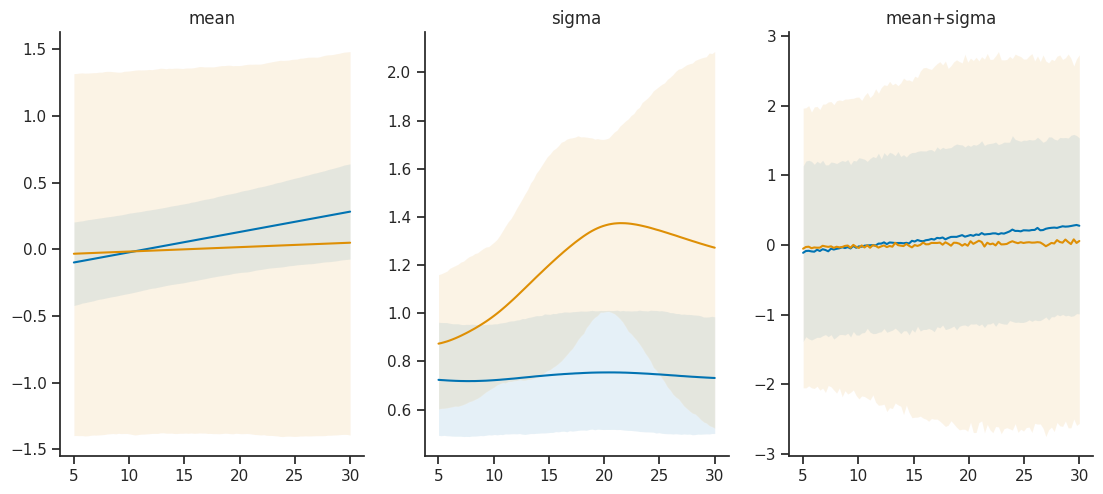

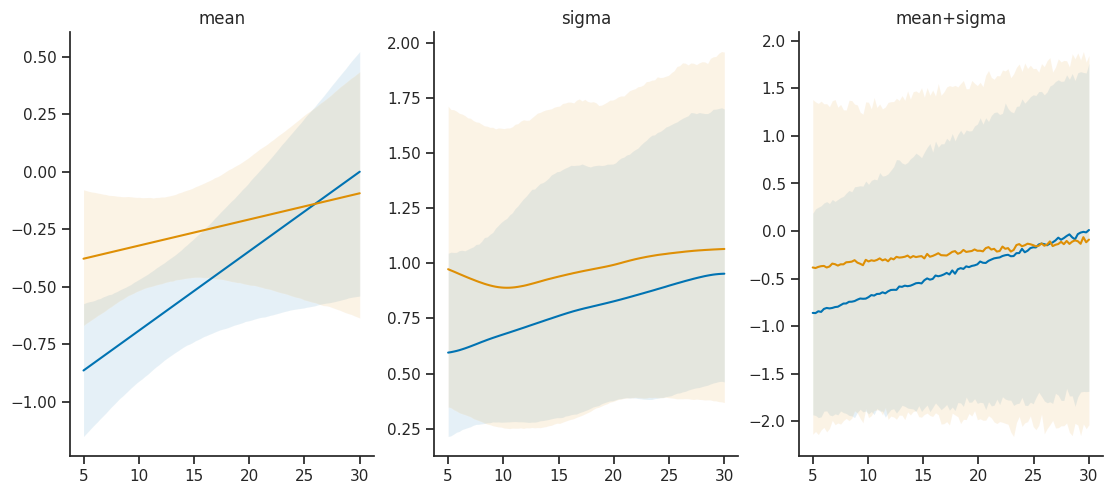

In [33]:
plot_mean(c_pred,c_std,c_mean,curve_phi,sigma_phi,N_alg,N_pred,N_ipn,N_split,N_macro_alg,
              N_macro_ipn)

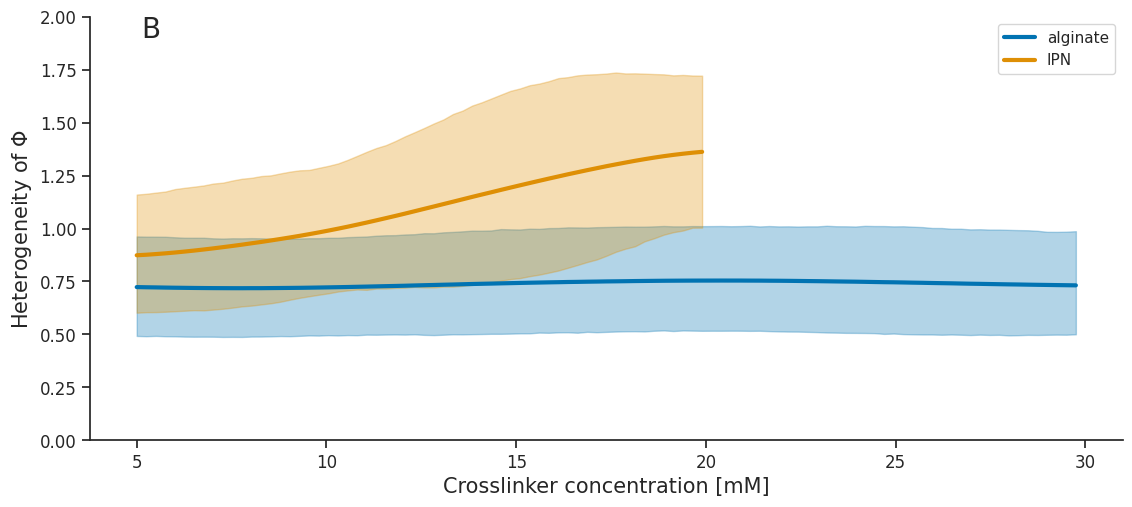

In [34]:
plot_heterogeneity(N_alg,N_ipn,N_pred,c_pred,crosslinker,type_indices,sigma_phi,c_std,c_mean,naming,units,xlabel,mec_type)

In [35]:
names = ['micro alginate','micro ipn','macro alginate','macro ipn']
for k in [jnp.squeeze(states_phi.slope1)]:
    ee = einops.rearrange(k, 'i j l -> (i j) l')
    for i,j in zip(range(ee.shape[-1]),names):
        print(np.sum(ee[:,i]>0.1)/ee[:,i].shape[0]*100)
    print('---')

58.475
21.95625
90.04375
46.51875
---


In [36]:
increase_in_heterogeneity(states_phi,cross_unique_alg,cross_unique_ipn,N_micro,c_std,
                              c_mean,N_alg,N_ipn,cross_unique_macro_alg,cross_unique_macro_ipn,
                              N_macro,N_macro_alg,N_macro_ipn,m1,m2)

alginate 10.0 20.0 13.52  
alginate 10.0 30.0 7.4  
alginate 20.0 30.0 1.48  
alginate 5.0 10.0 1.81  
alginate 5.0 20.0 15.76  
alginate 5.0 30.0 9.38  
alginate 5.0 7.5 0.04  
alginate 7.5 10.0 0.94  
alginate 7.5 20.0 16.71  
alginate 7.5 30.0 9.64  
ipn 10.0 20.0 99.91 **** 
ipn 5.0 10.0 58.24  
ipn 5.0 20.0 99.99 **** 


0.015125


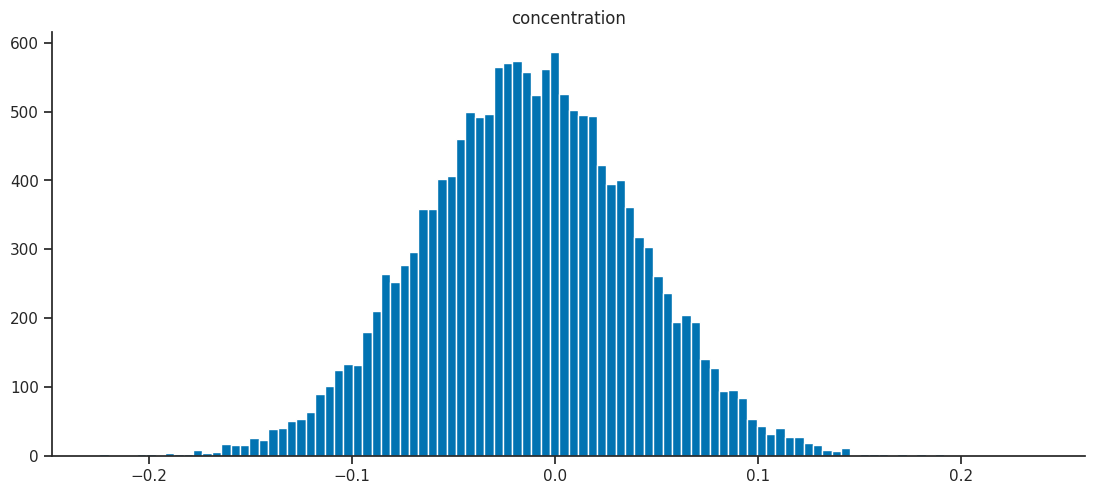

In [37]:
con = np.array(states_phi.concentration_mu.ravel())
_ = plt.hist(con,bins=100)
plt.title('concentration')
print((con>0.1).sum()/con.shape[0])

0.582625


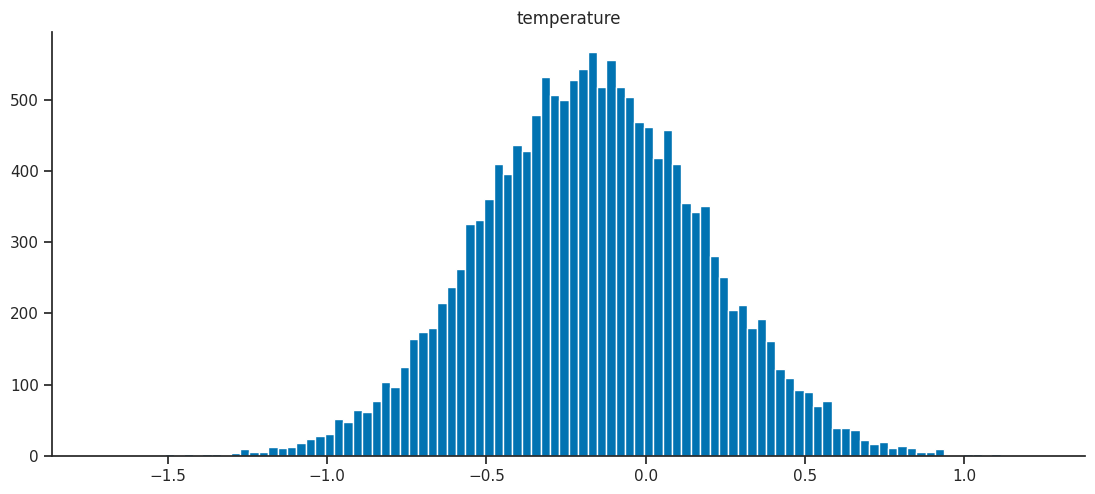

In [38]:
tm = np.array(states_phi.temperature_mu.ravel())
_ = plt.hist(tm,bins=100)
plt.title('temperature')
print((tm<-0.1).sum()/tm.shape[0])

## Combined plots

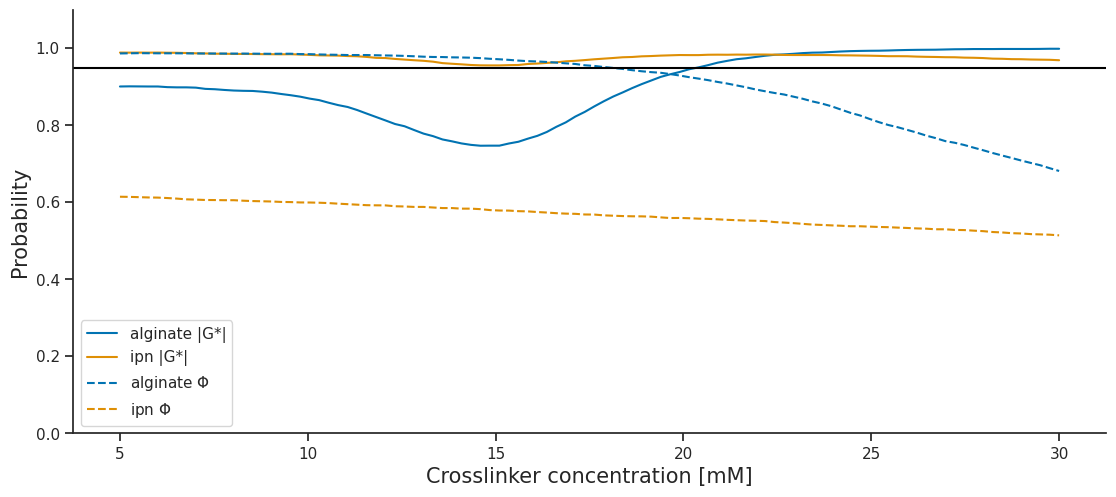

In [39]:
compare_micromacro(curve,curve_phi,c_pred,c_std,c_mean,xlabel)

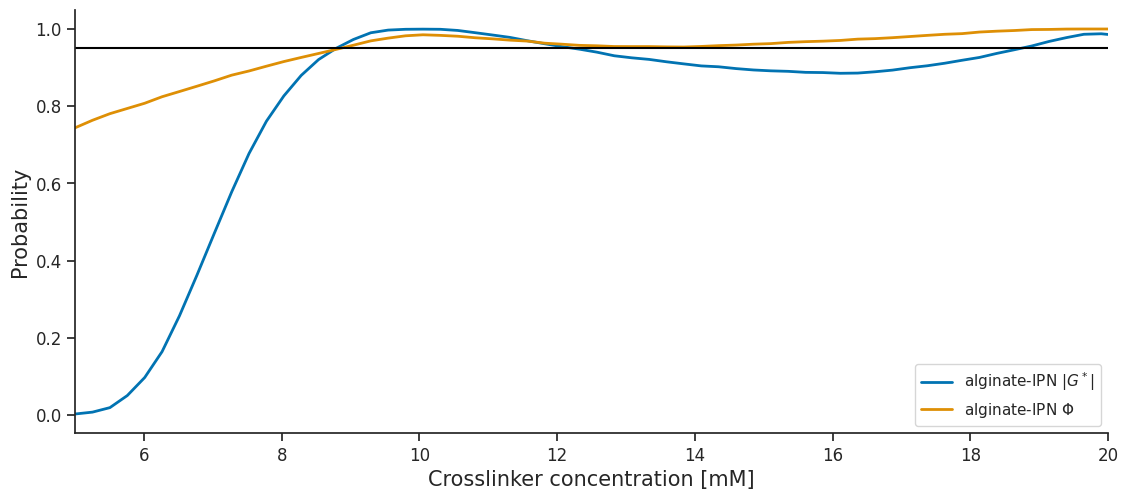

In [40]:
compare_heterogeneity(sigma,N_alg,N_pred,N_ipn,c_pred,c_std,c_mean,sigma_phi,xlabel)

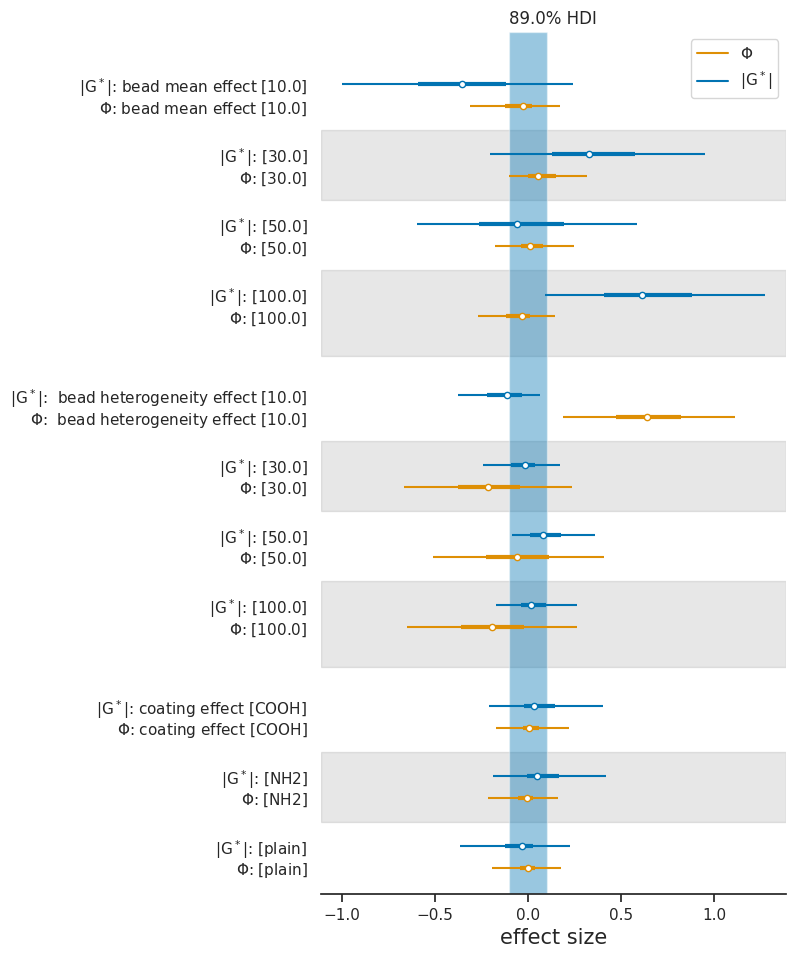

In [41]:
labeller = azl.MapLabeller(var_name_map={"radius_effect": "bead mean effect ",
                                         "coating_effect": "coating effect ",
                                         "radius_sigma_effect": " bead heterogeneity effect "})

ax = az.plot_forest([trace,trace_phi],
                    model_names = [r"|G$^*$|", r"$\Phi$"],
                    var_names=['radius_effect','radius_sigma_effect','coating_effect'],
                    combined=True,labeller=labeller,hdi_prob=0.89,colors=sns.color_palette('colorblind')[:2])
ax[0].axvspan(-0.1,0.1,alpha=0.4)

ax[0].set_xlabel('effect size',fontsize=15)
fig = ax[0].figure
#ax[0].text(0.05, 0.95, 'B', transform=ax[0].transAxes,fontsize=20)
fig.savefig(f'results/effects_both.png',bbox_inches = 'tight',dpi=300)
